# 1. Модуль A

## 1.1 Подготовка рабочего пространства

Для начала импортируем все необходимые библиотеки для работы с данным модулем. 

In [2]:
import pandas as pd
import os
import re
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2 Чтение данных

Укажем путь до папки с данными о работе датчиков.

In [134]:
BASE_PATH = 'out_sensor_data'

Считаем все пути к файлам с данными. Это нам понадобится для того, чтобы 

In [135]:
data_path_list = list(map(lambda s: f'{BASE_PATH}/{s}', os.listdir(BASE_PATH)))

Напишем функции, которые необходимы для чтения файлов с расширением .dat. Поскольку они не имеют явно заданной структуры. которую было бы удобно читать, будем обрабатывать последовательно строки с данными и выделять значения из них. Для этого будем использовать регулярные выражения, а также методы строк. В дальнейшем, эти данные отправятся в один единый файл .csv.

In [136]:
import re


def get_string(string: str) -> list[str]:
    elements = string.split()

    last_id = 0

    res = []

    for i, elem in enumerate(elements):
        if ':' in elem:
            try:
                word, value = elem.split(':')
            except:
                word = elem[:-1]
                value = ''
            key = ' '.join(elements[last_id : i]) + ' ' + word
            last_id = i + 1

            res.append(value)
    
    return res


def get_data_from_dat(dat_path: str) -> dict:
    res = []
    with open(dat_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    for line in lines:
        line = re.sub(r'\b\w*Sensors INFO\w*\b', '', line).strip()
        if '/  Time from device initiation:/  ' in line:
            line = re.sub('/  Time from device initiation:/  ', '', line)
        line = re.sub('/  ', '', re.sub(' /', '/', re.sub(' , ', '/', line)))
        
        string = get_string(line)

        res.append(string)
        
    return res

Считаем файл с информацией об испытуемых. Разделитель и кодировку можно не указывать, они стандартные.

In [141]:
participants_info = pd.read_csv('participants_Info.csv')
participants_info

,subj_id,gender,age,height_in,weight_lbs,race,right_handed
0,0,female,33,63,143,asian,0
1,1,female,43,70,224,asian,1
2,2,female,56,66,208,caucasian,1
3,3,female,35,64,107,caucasian,1
4,4,male,49,69,256,caucasian,0
...,...,...,...,...,...,...,...
195,195,female,36,65,133,black,0
196,196,female,27,67,124,asian,1
197,197,male,23,71,164,caucasian,1
198,198,female,47,73,164,caucasian,1


Напишем результирующие колонки для выходного набора данных, с которым будет производиться дальнейшая работа.

In [156]:
columns = [
    'subj_id', 'gender', 'age', 'height_in', 
    'weight_lbs', 'race', 'right_handed', 'time_s',
    'lw_x', 'lw_y', 'lw_z', 'lh_x', 'lh_y', 'lh_z',
    'la_xyz', 'ra_xyz', 
    'activity'
]

Напишем функцию, которая необходима для формирования .csv файлов с информацией о каждом испытуемом. И вызовем ее

In [161]:
def get_csv(data_path_list: list[str], participants_info: pd.DataFrame, columns: list[str], base_bath: str = 'csv') -> None:
    for i, (path, base_data) in enumerate(zip(data_path_list, participants_info.values)):
        base_data_list = list(base_data)
        sensor_data = get_data_from_dat(path)
        res = [base_data_list + d for d in sensor_data]
        pd.DataFrame(res, columns=columns).to_csv(f'{base_bath}/{i}.csv', index=False)

In [162]:
get_csv(data_path_list, participants_info, columns)

## 1.3 Формирование единого набора данных

Укажем путь до папки, в которой содержатся новые данные.

In [2]:
BASE_PATH_CSV = 'csv'

Получим пути до этих файлов аналогично тому, как мы это делали до этого.

In [3]:
data_path_csv_list = list(map(lambda s: f'{BASE_PATH_CSV}/{s}', os.listdir(BASE_PATH_CSV)))

Сформируем единый датафрейм со всей информацией обо всех датчиках, для всех испытуемых в каждый момент времени.

In [4]:
df = pd.concat(
    [pd.read_csv(path, low_memory=False) for path in data_path_csv_list]
)
df

,subj_id,gender,age,height_in,weight_lbs,race,right_handed,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_xyz,ra_xyz,activity
0,0,female,33,63,143,asian,0,0.0,0.086,-1.641,0.039,0.227,-1.102,-0.406,0.668/0.023/-0.035,-0.117/1.117/0.266,walking
1,0,female,33,63,143,asian,0,1.0,-0.098,-1.188,0.18,0.602,-1.262,0.246,-0.449/2.824/0.707,-0.137/1.051/0.207,walking
2,0,female,33,63,143,asian,0,2.0,0.508,-1.063,0.035,-0.004,-0.707,-0.488,0.703/2.172/0.191,0.129/1.699/0.449,walking
3,0,female,33,63,143,asian,0,3.0,-0.348,-1.488,0.504,-0.18,-0.816,-0.41,0.27/0.914/0.238,-0.512/2.266/1.41,walking
4,0,female,33,63,143,asian,0,4.0,-0.059,-1.066,0.395,0.09,-0.941,-0.258,0.07/0.984/0.211,-0.633/0.844/0.074,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27694,99,female,43,63,130,caucasian,0,27643.0,-0.688,0.43,Left,0.523,-1.75,-0.75,-1.469/3.09/1.441,-0.051/1.117/0.031,non-study
27695,99,female,43,63,130,caucasian,0,27644.0,0.0,0.0,0.0,-0.004,-0.305,-0.98,-0.129/0.035/0.988,-0.016/0.02/0.977,non-study
27696,99,female,43,63,130,caucasian,0,27645.0,-1.152,-0.074,-0.262,0.164,-0.883,Left,0.063,0.039/1.078/0.043,non-study
27697,99,female,43,63,130,caucasian,0,27646.0,0.199,-1.242,-0.051,Left,-0.957,-0.367,0.559/2.012/0.121,-0.094/1.031/0.32,non-study


Распарсим агрегированные атрибуты (la_xyz, ra_xyz) на три -- для каждой оси (x, y, z)

In [5]:
df[['la_x', 'la_y', 'la_z']] = df['la_xyz'].str.split('/', expand=True)
df.drop(columns=['la_xyz'], inplace=True)

In [6]:
df[['ra_x', 'ra_y', 'ra_z']] = df['ra_xyz'].str.split('/', expand=True)
df.drop(columns=['ra_xyz'], inplace=True)

Отобразим полученный результат.

In [7]:
df

,subj_id,gender,age,height_in,weight_lbs,race,right_handed,time_s,lw_x,lw_y,...,lh_x,lh_y,lh_z,activity,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,0,female,33,63,143,asian,0,0.0,0.086,-1.641,...,0.227,-1.102,-0.406,walking,0.668,0.023,-0.035,-0.117,1.117,0.266
1,0,female,33,63,143,asian,0,1.0,-0.098,-1.188,...,0.602,-1.262,0.246,walking,-0.449,2.824,0.707,-0.137,1.051,0.207
2,0,female,33,63,143,asian,0,2.0,0.508,-1.063,...,-0.004,-0.707,-0.488,walking,0.703,2.172,0.191,0.129,1.699,0.449
3,0,female,33,63,143,asian,0,3.0,-0.348,-1.488,...,-0.18,-0.816,-0.41,walking,0.27,0.914,0.238,-0.512,2.266,1.41
4,0,female,33,63,143,asian,0,4.0,-0.059,-1.066,...,0.09,-0.941,-0.258,walking,0.07,0.984,0.211,-0.633,0.844,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27694,99,female,43,63,130,caucasian,0,27643.0,-0.688,0.43,...,0.523,-1.75,-0.75,non-study,-1.469,3.09,1.441,-0.051,1.117,0.031
27695,99,female,43,63,130,caucasian,0,27644.0,0.0,0.0,...,-0.004,-0.305,-0.98,non-study,-0.129,0.035,0.988,-0.016,0.02,0.977
27696,99,female,43,63,130,caucasian,0,27645.0,-1.152,-0.074,...,0.164,-0.883,Left,non-study,0.063,None,None,0.039,1.078,0.043
27697,99,female,43,63,130,caucasian,0,27646.0,0.199,-1.242,...,Left,-0.957,-0.367,non-study,0.559,2.012,0.121,-0.094,1.031,0.32


Сохраним данные на диск для удобства.

In [180]:
df.to_csv('data.csv', index=False)

## 1.4 Предобработка данных

Выведем информацию о датасете

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4745376 entries, 0 to 27698
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   subj_id       int64  
 1   gender        object 
 2   age           int64  
 3   height_in     int64  
 4   weight_lbs    int64  
 5   race          object 
 6   right_handed  int64  
 7   time_s        float64
 8   lw_x          object 
 9   lw_y          object 
 10  lw_z          object 
 11  lh_x          object 
 12  lh_y          object 
 13  lh_z          object 
 14  activity      object 
 15  la_x          object 
 16  la_y          object 
 17  la_z          object 
 18  ra_x          object 
 19  ra_y          object 
 20  ra_z          object 
dtypes: float64(1), int64(5), object(15)
memory usage: 796.5+ MB


Установим необходимый тип данных. В случае необходимости и ошибки в данных установим служебный символ для того, чтобы заменить впоследствии пропуск

In [13]:
df['lw_x'] = pd.to_numeric(df['lw_x'], errors='coerce')
df['lw_y'] = pd.to_numeric(df['lw_y'], errors='coerce')
df['lw_z'] = pd.to_numeric(df['lw_z'], errors='coerce')
df['lh_x'] = pd.to_numeric(df['lh_x'], errors='coerce')
df['lh_y'] = pd.to_numeric(df['lh_y'], errors='coerce')
df['lh_z'] = pd.to_numeric(df['lh_z'], errors='coerce')
df['la_x'] = pd.to_numeric(df['la_x'], errors='coerce')
df['la_y'] = pd.to_numeric(df['la_y'], errors='coerce')
df['la_z'] = pd.to_numeric(df['la_z'], errors='coerce')
df['ra_x'] = pd.to_numeric(df['ra_x'], errors='coerce')
df['ra_y'] = pd.to_numeric(df['ra_y'], errors='coerce')
df['ra_z'] = pd.to_numeric(df['ra_z'], errors='coerce')

Вновь выведем информацию

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4745376 entries, 0 to 27698
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   subj_id       int64  
 1   gender        object 
 2   age           int64  
 3   height_in     int64  
 4   weight_lbs    int64  
 5   race          object 
 6   right_handed  int64  
 7   time_s        float64
 8   lw_x          float64
 9   lw_y          float64
 10  lw_z          float64
 11  lh_x          float64
 12  lh_y          float64
 13  lh_z          float64
 14  activity      object 
 15  la_x          float64
 16  la_y          float32
 17  la_z          float32
 18  ra_x          float64
 19  ra_y          float32
 20  ra_z          float32
dtypes: float32(4), float64(9), int64(5), object(3)
memory usage: 724.1+ MB


Рассмотрим уникальные активности

In [15]:
df['activity'].unique()

array(['walking', 'non-study', 'clapping', 'driving', 'ascending',
       'descending', nan], dtype=object)

Удалим активность, связанную с хлопаньем в ладоши

In [18]:
df = df[df['activity'] != 'clapping']
df['activity'].unique()

array(['walking', 'non-study', 'driving', 'ascending', 'descending', nan],
      dtype=object)

Изучим число пропусков в данных

In [23]:
df.isna().sum()

subj_id              0
gender               0
age                  0
height_in            0
weight_lbs           0
race                 0
right_handed         0
time_s               1
lw_x             18771
lw_y             32202
lw_z            189824
lh_x            237678
lh_y             28063
lh_z            189712
activity             1
la_x             30923
la_y             47903
la_z             47903
ra_x             47505
ra_y             47505
ra_z             47505
dtype: int64

Отбросим сразу же строчки, в которых по одному пропуску

In [26]:
df = df.dropna(subset=['time_s', 'activity'])

Визуализируем пропуски

<Axes: >

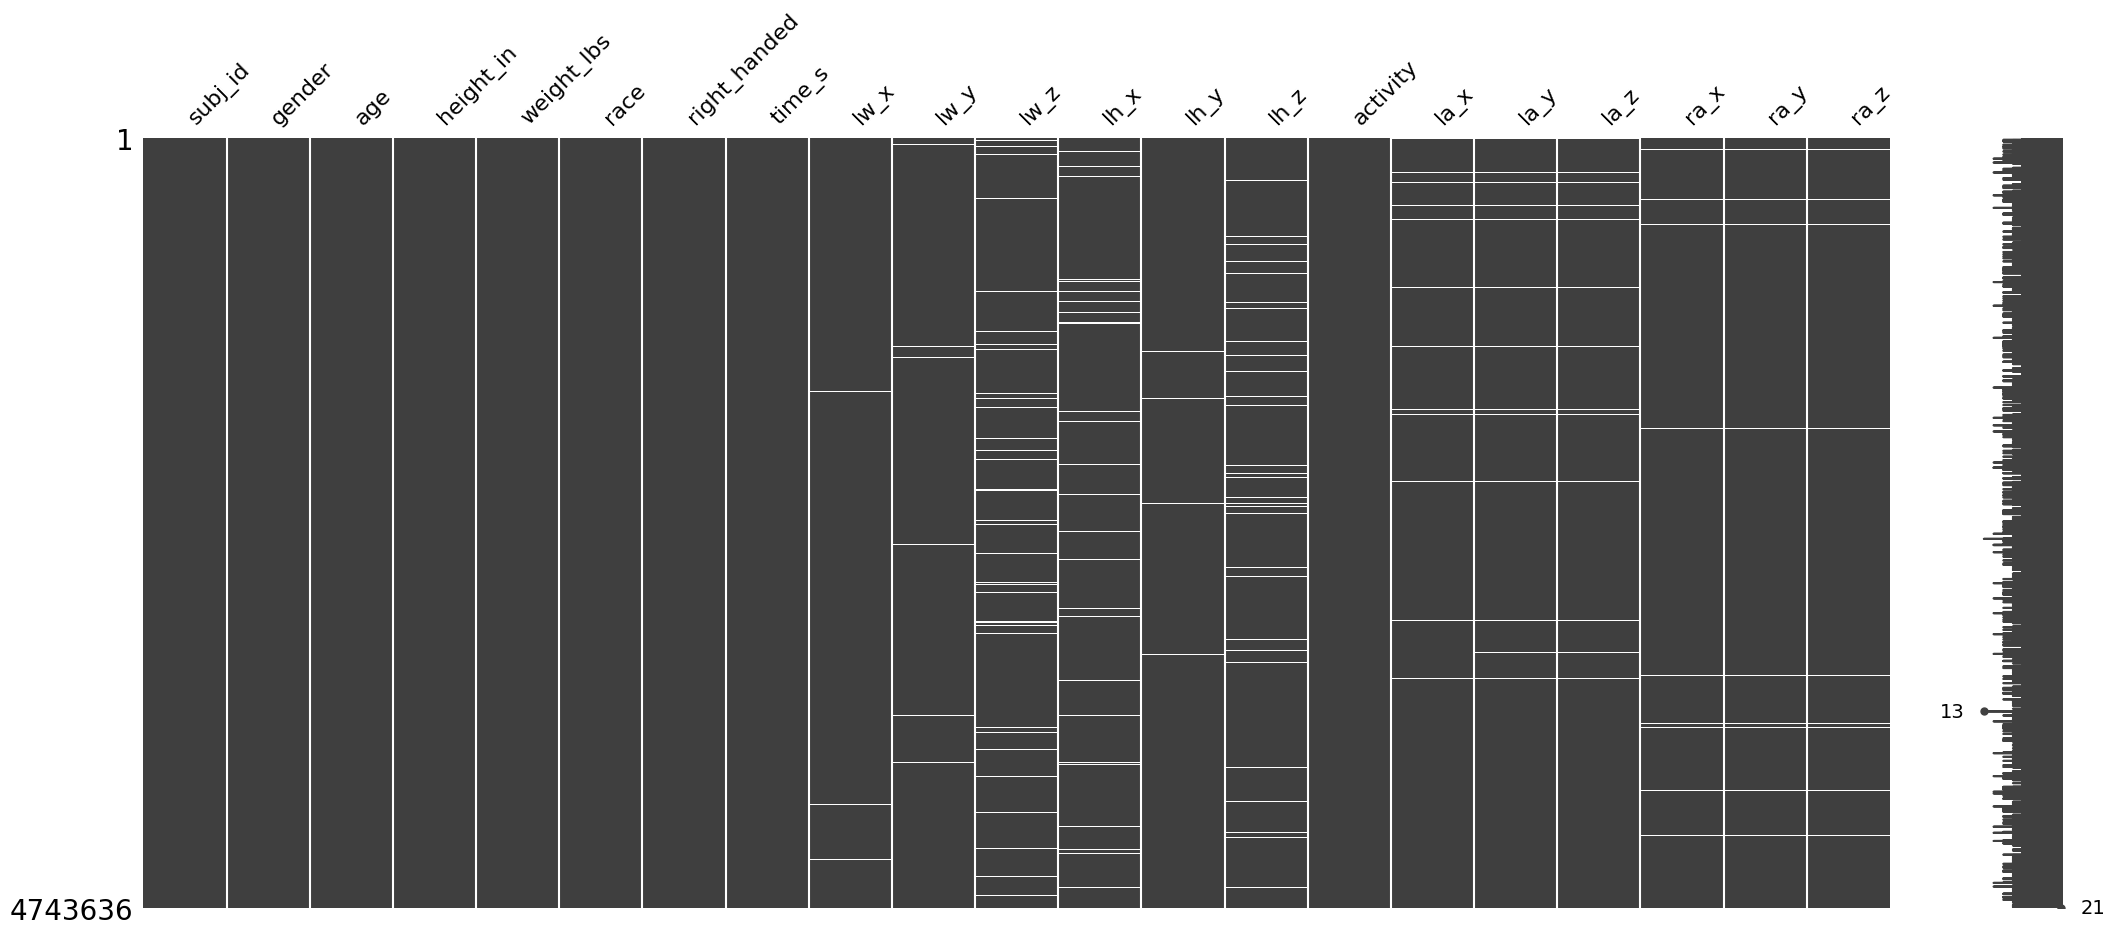

In [28]:
msno.matrix(df)

Будем исследовать признаки, которые имеют сравнительно небольшое число пропусков. Для этого рассмотрим плотности распределения признаков до заполнения средним занчением и после. Если распределение не сильно изменилось, значит, можно использовать данное заполнение.
Признаки с большим числом пропусков отбросим.

In [30]:
def test_density_fillna(df, col: str, val: float) -> None:
    sns.histplot(df[col], kde=True, stat='density')
    sns.histplot(df[col].fillna(val), kde=True, stat='density')

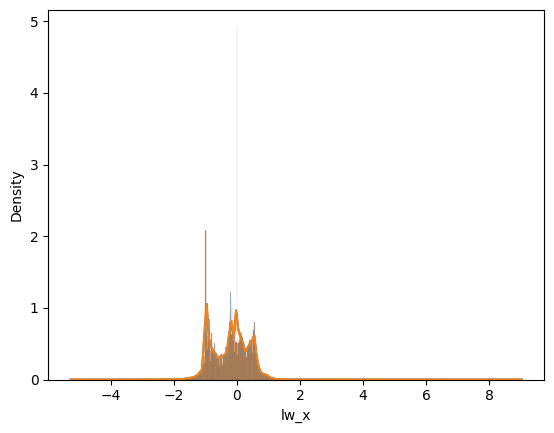

In [32]:
test_density_fillna(df, 'lw_x', df['lw_x'].median())

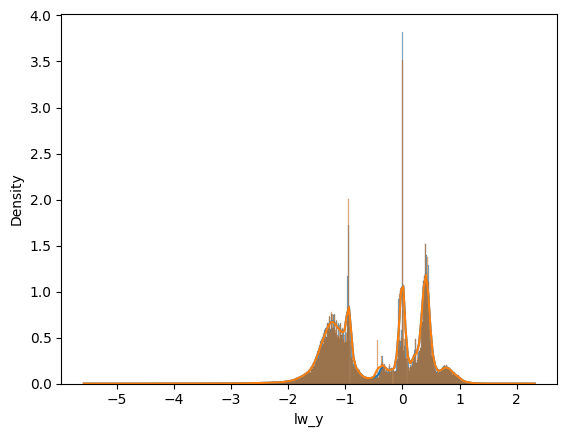

In [34]:
test_density_fillna(df, 'lw_y', df['lw_y'].mean())

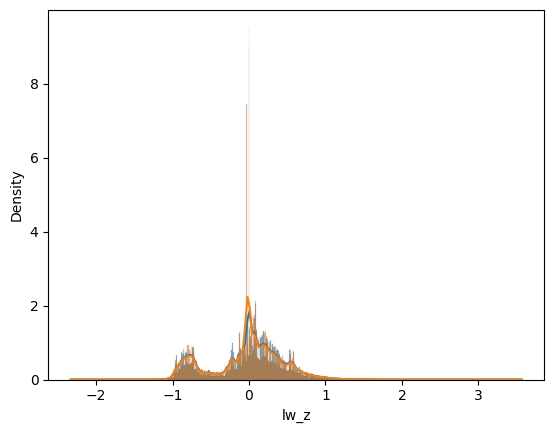

In [35]:
test_density_fillna(df, 'lw_z', df['lw_z'].mean())

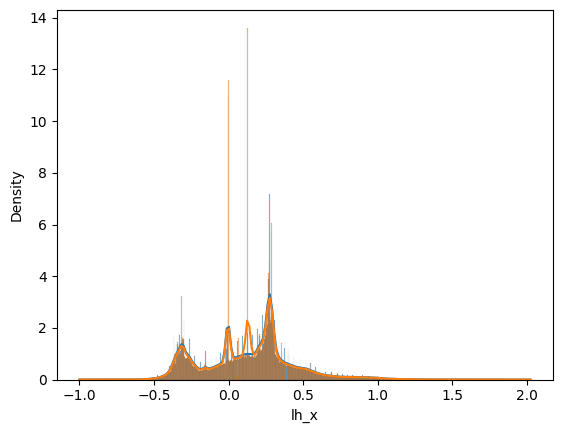

In [36]:
test_density_fillna(df, 'lh_x', df['lh_x'].mean())

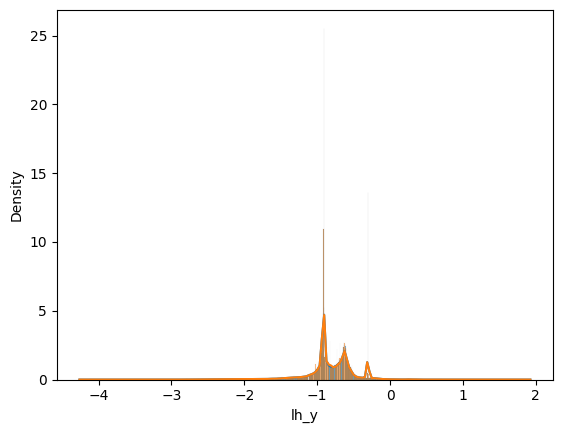

In [37]:
test_density_fillna(df, 'lh_y', df['lh_y'].mean())

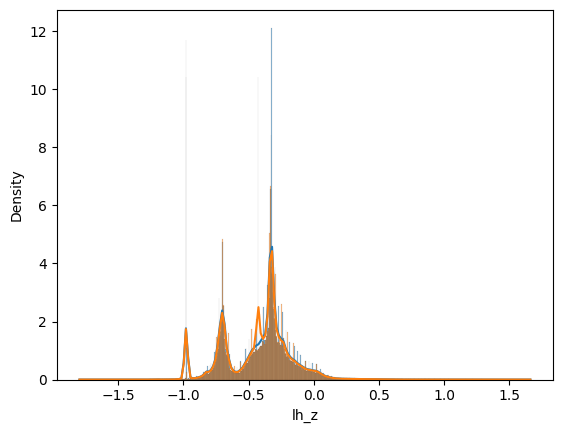

In [38]:
test_density_fillna(df, 'lh_z', df['lh_z'].mean())

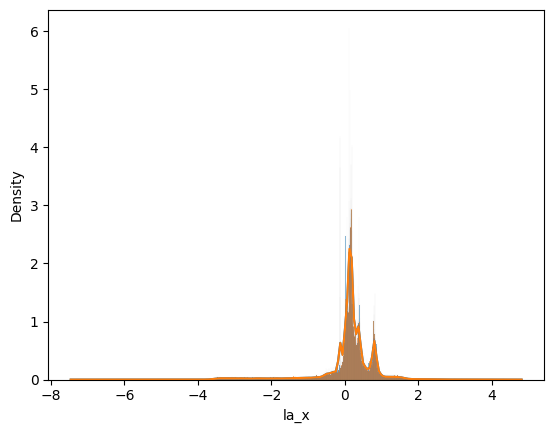

In [39]:
test_density_fillna(df, 'la_x', df['la_x'].mean())

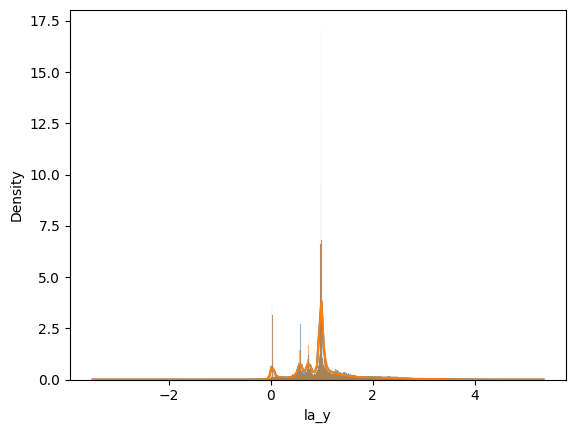

In [40]:
test_density_fillna(df, 'la_y', df['la_y'].mean())

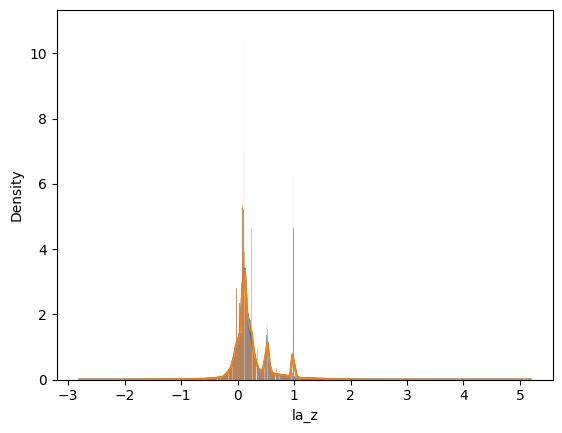

In [41]:
test_density_fillna(df, 'la_z', df['la_z'].mean())

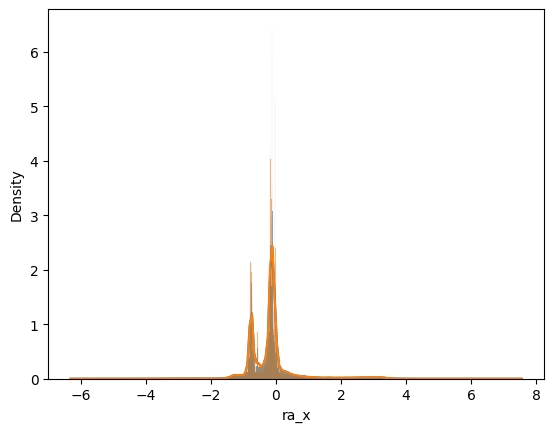

In [42]:
test_density_fillna(df, 'ra_x', df['ra_x'].mean())

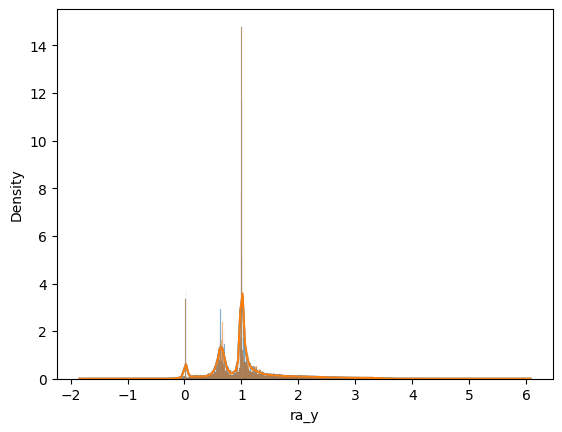

In [43]:
test_density_fillna(df, 'ra_y', df['ra_y'].mean())

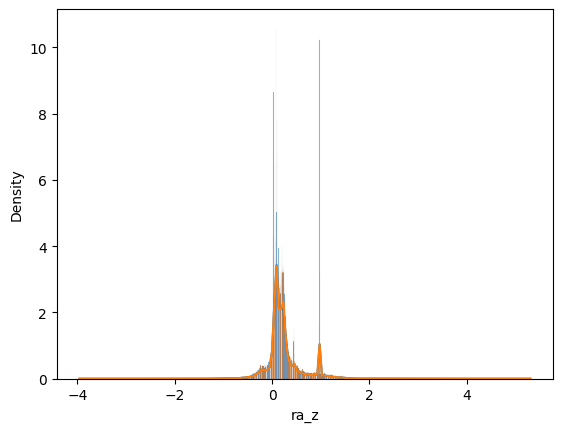

In [44]:
test_density_fillna(df, 'ra_z', df['ra_z'].mean())

In [45]:
df = df.dropna(subset=['lw_z', 'lh_x', 'lh_z'])

Плтность не меняется сильно, установим заполнение средним.

In [47]:
df[['lw_x', 'lw_y', 'lh_y', 'la_x', "la_y", "la_z", "ra_x", "ra_y", "ra_z"]] = df[[
    'lw_x', 'lw_y', 'lh_y', 'la_x', "la_y", "la_z", "ra_x", "ra_y", "ra_z"
    ]].fillna(df[['lw_x', 'lw_y', 'lh_y', 'la_x', "la_y", "la_z", "ra_x", "ra_y", "ra_z"]].mean())
df.isna().sum()

subj_id         0
gender          0
age             0
height_in       0
weight_lbs      0
race            0
right_handed    0
time_s          0
lw_x            0
lw_y            0
lw_z            0
lh_x            0
lh_y            0
lh_z            0
activity        0
la_x            0
la_y            0
la_z            0
ra_x            0
ra_y            0
ra_z            0
dtype: int64

Текстовое и статистическое описание признаков
- activity: Тип деятельности (“walking” = ходьба, “ascending” = подъем по лестнице;
“decending” =подъем по лестнице; “driving” = вождение автомобиля; “clapping” =
хлопание в ладоши; “non-study activities” = прочая деятельность)
- time_s: время с момента запуска устройства (секунды [с])
- lw_x: Измерение по оси X левого запястья (ускорение свободного падения [g])
- lw_y: Измерение по оси Y левого запястья (ускорение свободного падения [g])
- lw_z: Измерение по оси Z левого запястья (ускорение свободного падения [g])
- lh_x: Измерение по оси X левого бедра (ускорение свободного падения [g])
- lh_y: Измерение по оси Y левого бедра (ускорение свободного падения [g])
- lh_z: Измерение по оси Z левого бедра (ускорение свободного падения [g])
- la_x: Измерение по оси X левой лодыжки (ускорение свободного падения [g])
- la_y: Измерение по оси Y левой лодыжки (ускорение свободного падения [g])
- la_z: Измерение по оси Z левой лодыжки (ускорение свободного падения [g])
- ra_x: Измерение по оси X правой лодыжки (ускорение свободного падения [g])
- ra_y: Измерение по оси Y правой лодыжки (ускорение свободного падения [g])
- ra_z: Измерение по оси Z правой лодыжки (ускорение свободного падения [g])

In [48]:
df.describe()

,subj_id,age,height_in,weight_lbs,right_handed,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z
count,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06,4.152476e+06
mean,9.913334e+01,3.933788e+01,6.826702e+01,1.701826e+02,8.785662e-01,1.321315e+04,-2.093106e-01,-4.309785e-01,-2.960424e-02,1.294324e-01,-8.242771e-01,-4.270368e-01,1.144707e-01,1.047035e+00,2.460491e-01,-1.644383e-01,1.038825e+00,2.331009e-01
std,5.817254e+01,9.322219e+00,4.682481e+00,5.324929e+01,3.266308e-01,8.848419e+03,5.943167e-01,7.862530e-01,4.733835e-01,3.073354e-01,3.469751e-01,2.589912e-01,7.331313e-01,6.188176e-01,3.644992e-01,7.485048e-01,6.135008e-01,3.524018e-01
min,0.000000e+00,1.700000e+01,5.800000e+01,8.200000e+01,0.000000e+00,0.000000e+00,-5.273000e+00,-5.571392e+00,-2.332000e+00,-1.000000e+00,-4.262000e+00,-1.797000e+00,-7.461000e+00,-3.492000e+00,-2.801000e+00,-6.305000e+00,-1.844000e+00,-3.957000e+00
25%,4.800000e+01,3.200000e+01,6.400000e+01,1.310000e+02,1.000000e+00,5.920750e+03,-7.380000e-01,-1.148000e+00,-2.540000e-01,-7.000000e-02,-9.220000e-01,-6.600000e-01,3.500000e-02,7.420000e-01,7.800000e-02,-6.050000e-01,6.680000e-01,7.000000e-02
50%,9.900000e+01,3.900000e+01,6.900000e+01,1.560000e+02,1.000000e+00,1.195000e+04,-1.560000e-01,-2.930000e-01,2.000000e-02,1.680000e-01,-8.400000e-01,-3.550000e-01,1.640000e-01,9.880000e-01,1.520000e-01,-1.600000e-01,1.004000e+00,1.600000e-01
75%,1.500000e+02,4.700000e+01,7.200000e+01,1.990000e+02,1.000000e+00,1.936600e+04,2.070000e-01,3.360000e-01,2.660000e-01,2.930000e-01,-6.290000e-01,-2.850000e-01,3.830000e-01,1.145000e+00,3.520000e-01,-4.700000e-02,1.125000e+00,2.890000e-01
max,1.990000e+02,6.100000e+01,7.900000e+01,3.230000e+02,1.000000e+00,4.416700e+04,9.028589e+00,2.312565e+00,3.566000e+00,2.023000e+00,1.926000e+00,1.660000e+00,4.734000e+00,5.352000e+00,5.184000e+00,7.551000e+00,6.074000e+00,5.305000e+00


Удалим дубли в данных

In [49]:
df.drop_duplicates(inplace=True)

In [50]:
df

,subj_id,gender,age,height_in,weight_lbs,race,right_handed,time_s,lw_x,lw_y,...,lh_x,lh_y,lh_z,activity,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,0,female,33,63,143,asian,0,0.0,0.086,-1.641,...,0.227,-1.102,-0.406,walking,0.668,0.023,-0.035,-0.117,1.117,0.266
1,0,female,33,63,143,asian,0,1.0,-0.098,-1.188,...,0.602,-1.262,0.246,walking,-0.449,2.824,0.707,-0.137,1.051,0.207
2,0,female,33,63,143,asian,0,2.0,0.508,-1.063,...,-0.004,-0.707,-0.488,walking,0.703,2.172,0.191,0.129,1.699,0.449
3,0,female,33,63,143,asian,0,3.0,-0.348,-1.488,...,-0.180,-0.816,-0.410,walking,0.270,0.914,0.238,-0.512,2.266,1.410
4,0,female,33,63,143,asian,0,4.0,-0.059,-1.066,...,0.090,-0.941,-0.258,walking,0.070,0.984,0.211,-0.633,0.844,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27690,99,female,43,63,130,caucasian,0,27639.0,-0.855,0.355,...,0.059,-0.672,-0.355,non-study,0.043,1.199,0.266,-0.902,1.008,0.172
27691,99,female,43,63,130,caucasian,0,27640.0,-0.813,0.281,...,0.098,-1.063,-0.496,non-study,-0.449,0.793,0.008,-0.152,0.438,0.160
27692,99,female,43,63,130,caucasian,0,27641.0,-0.098,-0.961,...,0.301,-0.926,-0.250,non-study,0.051,1.004,0.141,-0.168,0.996,0.117
27695,99,female,43,63,130,caucasian,0,27644.0,0.000,0.000,...,-0.004,-0.305,-0.980,non-study,-0.129,0.035,0.988,-0.016,0.020,0.977


In [51]:
df.to_csv('prep.csv', index=False)

# 2. Модуль B

In [3]:
df = pd.read_csv('prep.csv')
df

,subj_id,gender,age,height_in,weight_lbs,race,right_handed,time_s,lw_x,lw_y,...,lh_x,lh_y,lh_z,activity,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,0,female,33,63,143,asian,0,0.0,0.086,-1.641,...,0.227,-1.102,-0.406,walking,0.668,0.023,-0.035,-0.117,1.117,0.266
1,0,female,33,63,143,asian,0,1.0,-0.098,-1.188,...,0.602,-1.262,0.246,walking,-0.449,2.824,0.707,-0.137,1.051,0.207
2,0,female,33,63,143,asian,0,2.0,0.508,-1.063,...,-0.004,-0.707,-0.488,walking,0.703,2.172,0.191,0.129,1.699,0.449
3,0,female,33,63,143,asian,0,3.0,-0.348,-1.488,...,-0.180,-0.816,-0.410,walking,0.270,0.914,0.238,-0.512,2.266,1.410
4,0,female,33,63,143,asian,0,4.0,-0.059,-1.066,...,0.090,-0.941,-0.258,walking,0.070,0.984,0.211,-0.633,0.844,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144429,99,female,43,63,130,caucasian,0,27639.0,-0.855,0.355,...,0.059,-0.672,-0.355,non-study,0.043,1.199,0.266,-0.902,1.008,0.172
4144430,99,female,43,63,130,caucasian,0,27640.0,-0.813,0.281,...,0.098,-1.063,-0.496,non-study,-0.449,0.793,0.008,-0.152,0.438,0.160
4144431,99,female,43,63,130,caucasian,0,27641.0,-0.098,-0.961,...,0.301,-0.926,-0.250,non-study,0.051,1.004,0.141,-0.168,0.996,0.117
4144432,99,female,43,63,130,caucasian,0,27644.0,0.000,0.000,...,-0.004,-0.305,-0.980,non-study,-0.129,0.035,0.988,-0.016,0.020,0.977


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144434 entries, 0 to 4144433
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   subj_id       int64  
 1   gender        object 
 2   age           int64  
 3   height_in     int64  
 4   weight_lbs    int64  
 5   race          object 
 6   right_handed  int64  
 7   time_s        float64
 8   lw_x          float64
 9   lw_y          float64
 10  lw_z          float64
 11  lh_x          float64
 12  lh_y          float64
 13  lh_z          float64
 14  activity      object 
 15  la_x          float64
 16  la_y          float64
 17  la_z          float64
 18  ra_x          float64
 19  ra_y          float64
 20  ra_z          float64
dtypes: float64(13), int64(5), object(3)
memory usage: 664.0+ MB


## 2.1 Подбор алгоритмов выявления зависимостей

Алгоритмы для оценки степени влияния на целевую переменную:
- линейная корреляция (построение тепловой карты);
- 

# 3. Модуль С

Сперва необходимо привести категориальные признаки к числовым. Для этого будем использовать LabelEncoder, котоырй каждой категориальной метке присуждает числовую. Использовать будем именно его, так как в исходном наборе данных имеется большое количество признаков, и чтобы не порождать еще больше, например, при помощи one-hot кодирования, будем использовать этот (оптимальнее по времени вычисления моделей)

In [4]:
from sklearn.preprocessing import LabelEncoder

gender_le = LabelEncoder()
df['gender']= gender_le.fit_transform(df['gender'])

race_le = LabelEncoder()
df['race']= race_le.fit_transform(df['race'])

activity_le = LabelEncoder()
df['activity']= activity_le.fit_transform(df['activity']) 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144434 entries, 0 to 4144433
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   subj_id       int64  
 1   gender        int32  
 2   age           int64  
 3   height_in     int64  
 4   weight_lbs    int64  
 5   race          int32  
 6   right_handed  int64  
 7   time_s        float64
 8   lw_x          float64
 9   lw_y          float64
 10  lw_z          float64
 11  lh_x          float64
 12  lh_y          float64
 13  lh_z          float64
 14  activity      int32  
 15  la_x          float64
 16  la_y          float64
 17  la_z          float64
 18  ra_x          float64
 19  ra_y          float64
 20  ra_z          float64
dtypes: float64(13), int32(3), int64(5)
memory usage: 616.6 MB


ВЫделим признаковое пространство и пространство ответов

In [6]:
X = df.drop(columns=['activity'])
y = df['activity']

In [6]:
X

,subj_id,gender,age,height_in,weight_lbs,race,right_handed,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,0,0,33,63,143,0,0,0.0,0.086,-1.641,0.039,0.227,-1.102,-0.406,0.668,0.023,-0.035,-0.117,1.117,0.266
1,0,0,33,63,143,0,0,1.0,-0.098,-1.188,0.180,0.602,-1.262,0.246,-0.449,2.824,0.707,-0.137,1.051,0.207
2,0,0,33,63,143,0,0,2.0,0.508,-1.063,0.035,-0.004,-0.707,-0.488,0.703,2.172,0.191,0.129,1.699,0.449
3,0,0,33,63,143,0,0,3.0,-0.348,-1.488,0.504,-0.180,-0.816,-0.410,0.270,0.914,0.238,-0.512,2.266,1.410
4,0,0,33,63,143,0,0,4.0,-0.059,-1.066,0.395,0.090,-0.941,-0.258,0.070,0.984,0.211,-0.633,0.844,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144429,99,0,43,63,130,2,0,27639.0,-0.855,0.355,-0.051,0.059,-0.672,-0.355,0.043,1.199,0.266,-0.902,1.008,0.172
4144430,99,0,43,63,130,2,0,27640.0,-0.813,0.281,-0.176,0.098,-1.063,-0.496,-0.449,0.793,0.008,-0.152,0.438,0.160
4144431,99,0,43,63,130,2,0,27641.0,-0.098,-0.961,0.125,0.301,-0.926,-0.250,0.051,1.004,0.141,-0.168,0.996,0.117
4144432,99,0,43,63,130,2,0,27644.0,0.000,0.000,0.000,-0.004,-0.305,-0.980,-0.129,0.035,0.988,-0.016,0.020,0.977


In [7]:
y

0          4
1          4
2          4
3          4
4          4
          ..
4144429    3
4144430    3
4144431    3
4144432    3
4144433    3
Name: activity, Length: 4144434, dtype: int32

Исследуем вопрос дисбаланса классов для классификации. Для этого построим круговую диаграмму.

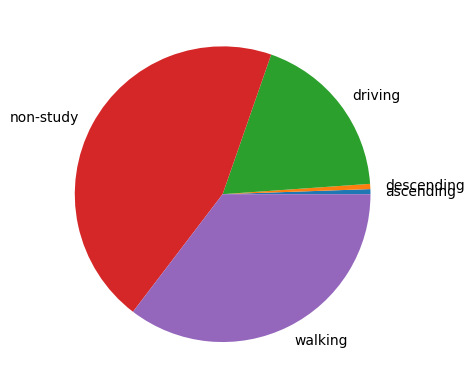

In [7]:
import numpy as np

labels, d = np.unique(df['activity'].values, return_counts=True)
plt.pie(d, labels=activity_le.classes_);

Видим, что в данных присутствует очень сильын дисбаланс классов. Две метки практически не представлены в датасете. Поэтому будем обрезать данные по числу наименьшего экземпляра.

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

Рассмотрим снова круговую диаграмму. Дисбаланс устранен, можно приступать к обучению.

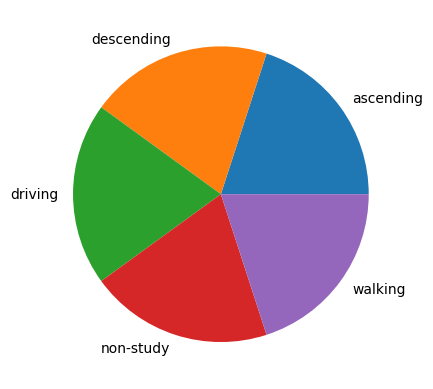

In [9]:
labels, d = np.unique(y_balanced.values, return_counts=True)
plt.pie(d, labels=activity_le.classes_);

## 3.2 Моделирование для сбалансированных данных

Импортируем необходимые инструменты для работы с данными

In [10]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_curve

### 3.2.1 Построение классификатора

Разделим данные на обучающие, тестирующие и валидационные выборки.

Обучающая выборка необходима для того, чтобы осуществлять процесс обучения. От общего числа данных в обучение пойдет 70% данны. Остальные 30% отправятся на валидацию и тест.

Данные необходимо перемешать в случайном порядке. поскольку на атрибутах в временем тика работы датчика построено отношения порядка (данные возрастают), а нам необходимо обеспечить репрезентативность обучения. По этой же причине присутствует стратификация, поскольку нам необходимо сохранить распределение меток классов при делении выборок, чтобы на проверке работы модели побывали все представители классов.

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_test_, y_train, y_test_ = train_test_split(X_balanced, y_balanced, test_size=0.3, shuffle=True, stratify=y_balanced)

Тестирующая выборка нужна для того, чтобы осуществлять подбор гиперпараметров. От оставшихся 30% данных мы берем под это 60%.
Валидационная выборка нужна для того, чтобы судить об общем качестве модели. На нее мы направляем 40% от остатка.

In [12]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.4, shuffle=True, stratify=y_test_)

#### 3.2.1.1 KNN

Попробуем обучить модель KNN и проверить результат на выборках. Данный алгоритм относится к простейшим моделям классификации, однако существует подозрение по поводу присутствия условия компактности в данных. Поэтому обучим данную модель и проанализируем результат.

In [40]:
from sklearn.neighbors import KNeighborsClassifier


grid_knn = {
    'n_neighbors': range(5, 10, 2)
}

knn = GridSearchCV(KNeighborsClassifier(), grid_knn).fit(X_train, y_train).best_estimator_
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4105
           1       0.83      1.00      0.90      4105
           2       0.49      0.57      0.52      4105
           3       0.46      0.38      0.42      4105
           4       0.50      0.32      0.39      4104

    accuracy                           0.65     20524
   macro avg       0.62      0.65      0.63     20524
weighted avg       0.62      0.65      0.63     20524



In [41]:
valid_predict_knn = knn.predict(X_valid)

In [42]:
print(balanced_accuracy_score(valid_predict_knn, y_valid))

0.6279034969214542


In [43]:
print(classification_report(valid_predict_knn, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3310
           1       1.00      0.83      0.90      3290
           2       0.57      0.50      0.53      3131
           3       0.37      0.47      0.41      2184
           4       0.34      0.52      0.41      1769

    accuracy                           0.65     13684
   macro avg       0.65      0.63      0.63     13684
weighted avg       0.71      0.65      0.68     13684



Видно, что модель отлично справилась на тех классах, которые изначально были представлены в большинстве. Но есть провалы с некоторыми классами. Поэтому модель не подходит, будем пробовать дальше.

#### 3.2.1.2 CatBoost

Попробуем обучить модель CatBoost и проверить результат на выборках. CatBoost -- представитель ансамблиевых моделей градиентного бустинга. Такие модели отлично справляются со сложными структурами данных.

In [50]:
from catboost import CatBoostClassifier


cat_grid = {
    'iterations': [100, 200, 300], 
    'learning_rate': [0.1, 0.5, 1]
}

cat = GridSearchCV(CatBoostClassifier(), cat_grid).fit(X_train, y_train).best_estimator_
y_pred = cat.predict(X_test)

0:	learn: 1.4461353	total: 25.5ms	remaining: 2.52s
1:	learn: 1.3368355	total: 48.7ms	remaining: 2.38s
2:	learn: 1.2508732	total: 72ms	remaining: 2.33s
3:	learn: 1.1829917	total: 111ms	remaining: 2.67s
4:	learn: 1.1182681	total: 133ms	remaining: 2.53s
5:	learn: 1.0637342	total: 175ms	remaining: 2.73s
6:	learn: 1.0179544	total: 197ms	remaining: 2.61s
7:	learn: 0.9751979	total: 219ms	remaining: 2.52s
8:	learn: 0.9399556	total: 242ms	remaining: 2.45s
9:	learn: 0.9064724	total: 266ms	remaining: 2.39s
10:	learn: 0.8787424	total: 315ms	remaining: 2.55s
11:	learn: 0.8545775	total: 367ms	remaining: 2.69s
12:	learn: 0.8288986	total: 395ms	remaining: 2.64s
13:	learn: 0.8094084	total: 418ms	remaining: 2.57s
14:	learn: 0.7877176	total: 443ms	remaining: 2.51s
15:	learn: 0.7700269	total: 466ms	remaining: 2.45s
16:	learn: 0.7521513	total: 489ms	remaining: 2.39s
17:	learn: 0.7351053	total: 511ms	remaining: 2.33s
18:	learn: 0.7204481	total: 531ms	remaining: 2.27s
19:	learn: 0.7046911	total: 553ms	remain

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4105
           1       0.96      0.97      0.96      4105
           2       1.00      1.00      1.00      4105
           3       0.96      0.94      0.95      4105
           4       0.96      0.96      0.96      4104

    accuracy                           0.97     20524
   macro avg       0.97      0.97      0.97     20524
weighted avg       0.97      0.97      0.97     20524



In [52]:
valid_predict_cat = cat.predict(X_valid)

In [53]:
print(classification_report(valid_predict_cat, y_valid))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2760
           1       0.97      0.96      0.96      2764
           2       1.00      1.00      1.00      2737
           3       0.94      0.96      0.95      2688
           4       0.95      0.95      0.95      2735

    accuracy                           0.97     13684
   macro avg       0.97      0.97      0.97     13684
weighted avg       0.97      0.97      0.97     13684



In [54]:
print(balanced_accuracy_score(valid_predict_cat, y_valid))

0.9671112154508531


Как видно из результатов, модель показала себя наилучшим образом (забегая вперед -- это лучшая модель из трех).

#### 3.2.1.3 Логистическая регрессия

Попробуем обучить модель LR и проверить результат на выборках. Данная модель относится к представителям линейных моделей. Проверим, присутствуют ли линейные зависимости между данными.

In [14]:
from sklearn.linear_model import LogisticRegression


grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet']
}

lr = GridSearchCV(LogisticRegression(), grid_lr).fit(X_train, y_train).best_estimator_
y_pred = lr.predict(X_test)

c:\Users\bugae\Desktop\fit-predict\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\bugae\Desktop\fit-predict\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.45      0.31      4104
           1       0.18      0.09      0.12      4105
           2       0.40      0.34      0.37      4105
           3       0.22      0.10      0.14      4105
           4       0.24      0.30      0.26      4105

    accuracy                           0.26     20524
   macro avg       0.25      0.26      0.24     20524
weighted avg       0.25      0.26      0.24     20524



In [16]:
valid_predict_lr = lr.predict(X_valid)

In [17]:
print(classification_report(valid_predict_lr, y_valid))

              precision    recall  f1-score   support

           0       0.44      0.23      0.30      5251
           1       0.09      0.18      0.12      1334
           2       0.34      0.39      0.36      2368
           3       0.11      0.25      0.15      1170
           4       0.32      0.24      0.28      3561

    accuracy                           0.26     13684
   macro avg       0.26      0.26      0.24     13684
weighted avg       0.33      0.26      0.27     13684



In [18]:
print(balanced_accuracy_score(valid_predict_lr, y_valid))

0.25917769055607964


Как видно из результатов, модель показала ужасную способность к обучению, ее использовать нельзя.

## 3.3 Кластеризация

### 3.3.1 Понижение пространства

Для того, чтобы применять алгоритмы кластеризации, необходимо понизить исходное пространство до двух признаков, чтобы успешно визуализировать данные. Для этого будем использовать алгоритм UMAP, который успешно справляется с данными с нелинейными зависимостями.

In [20]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X_balanced, y_balanced)

c:\Users\bugae\Desktop\fit-predict\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [23]:
embedding.shape

(114025, 2)

In [26]:
import numpy as np

def draw(X: np.ndarray, y: np.ndarray) -> None:
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
    plt.show()

In [28]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

### 3.3.2 KMEANS

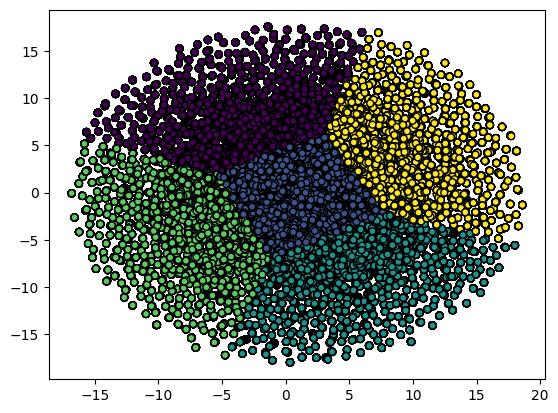

In [34]:
kmeans = KMeans(5).fit(embedding)
draw(embedding, kmeans.labels_)

В результате кластеризации видим четкую структуру кластеров и их линейную разделимость в новом признаковом пространстве

### 3.3.3 DBSCAN

In [39]:
clustering = DBSCAN(eps=3, min_samples=5).fit(embedding)


MemoryError: bad allocation

## 3.4 Оценка качества модели класссификации на отложенной выборке